In [35]:
from statsforecast import StatsForecast
from statsforecast.models import (Naive, SeasonalNaive, AutoARIMA, AutoTheta, AutoETS)
from datasetsforecast.losses import mse, mae, smape
from data_loading_finance.loading_data import LoadingData
from ts_tools.tools import tools
import yfinance as yf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore


from typing import List, Callable
from distributed import Client
from fugue import transform
from fugue_dask import DaskExecutionEngine

import warnings
warnings.filterwarnings("ignore")

In [36]:
# Descargar datos
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'IBM', 'BTC-USD']
Y_df = yf.download(tickers, start='2015-01-01', end='2023-12-31', interval='1mo')['Adj Close']

# Resetear el índice y transformar el DataFrame
Y_df = Y_df.reset_index().melt(id_vars='Date', var_name='unique_id', value_name='y')
Y_df = Y_df.rename(columns={'Date': 'ds'})

# Calcular los retornos
Y_df['y'] = np.log(Y_df['y'].div(Y_df.groupby('unique_id')['y'].shift(1)))
Y_df = Y_df.dropna(subset=['y']).reset_index(drop=True)

[*********************100%%**********************]  8 of 8 completed


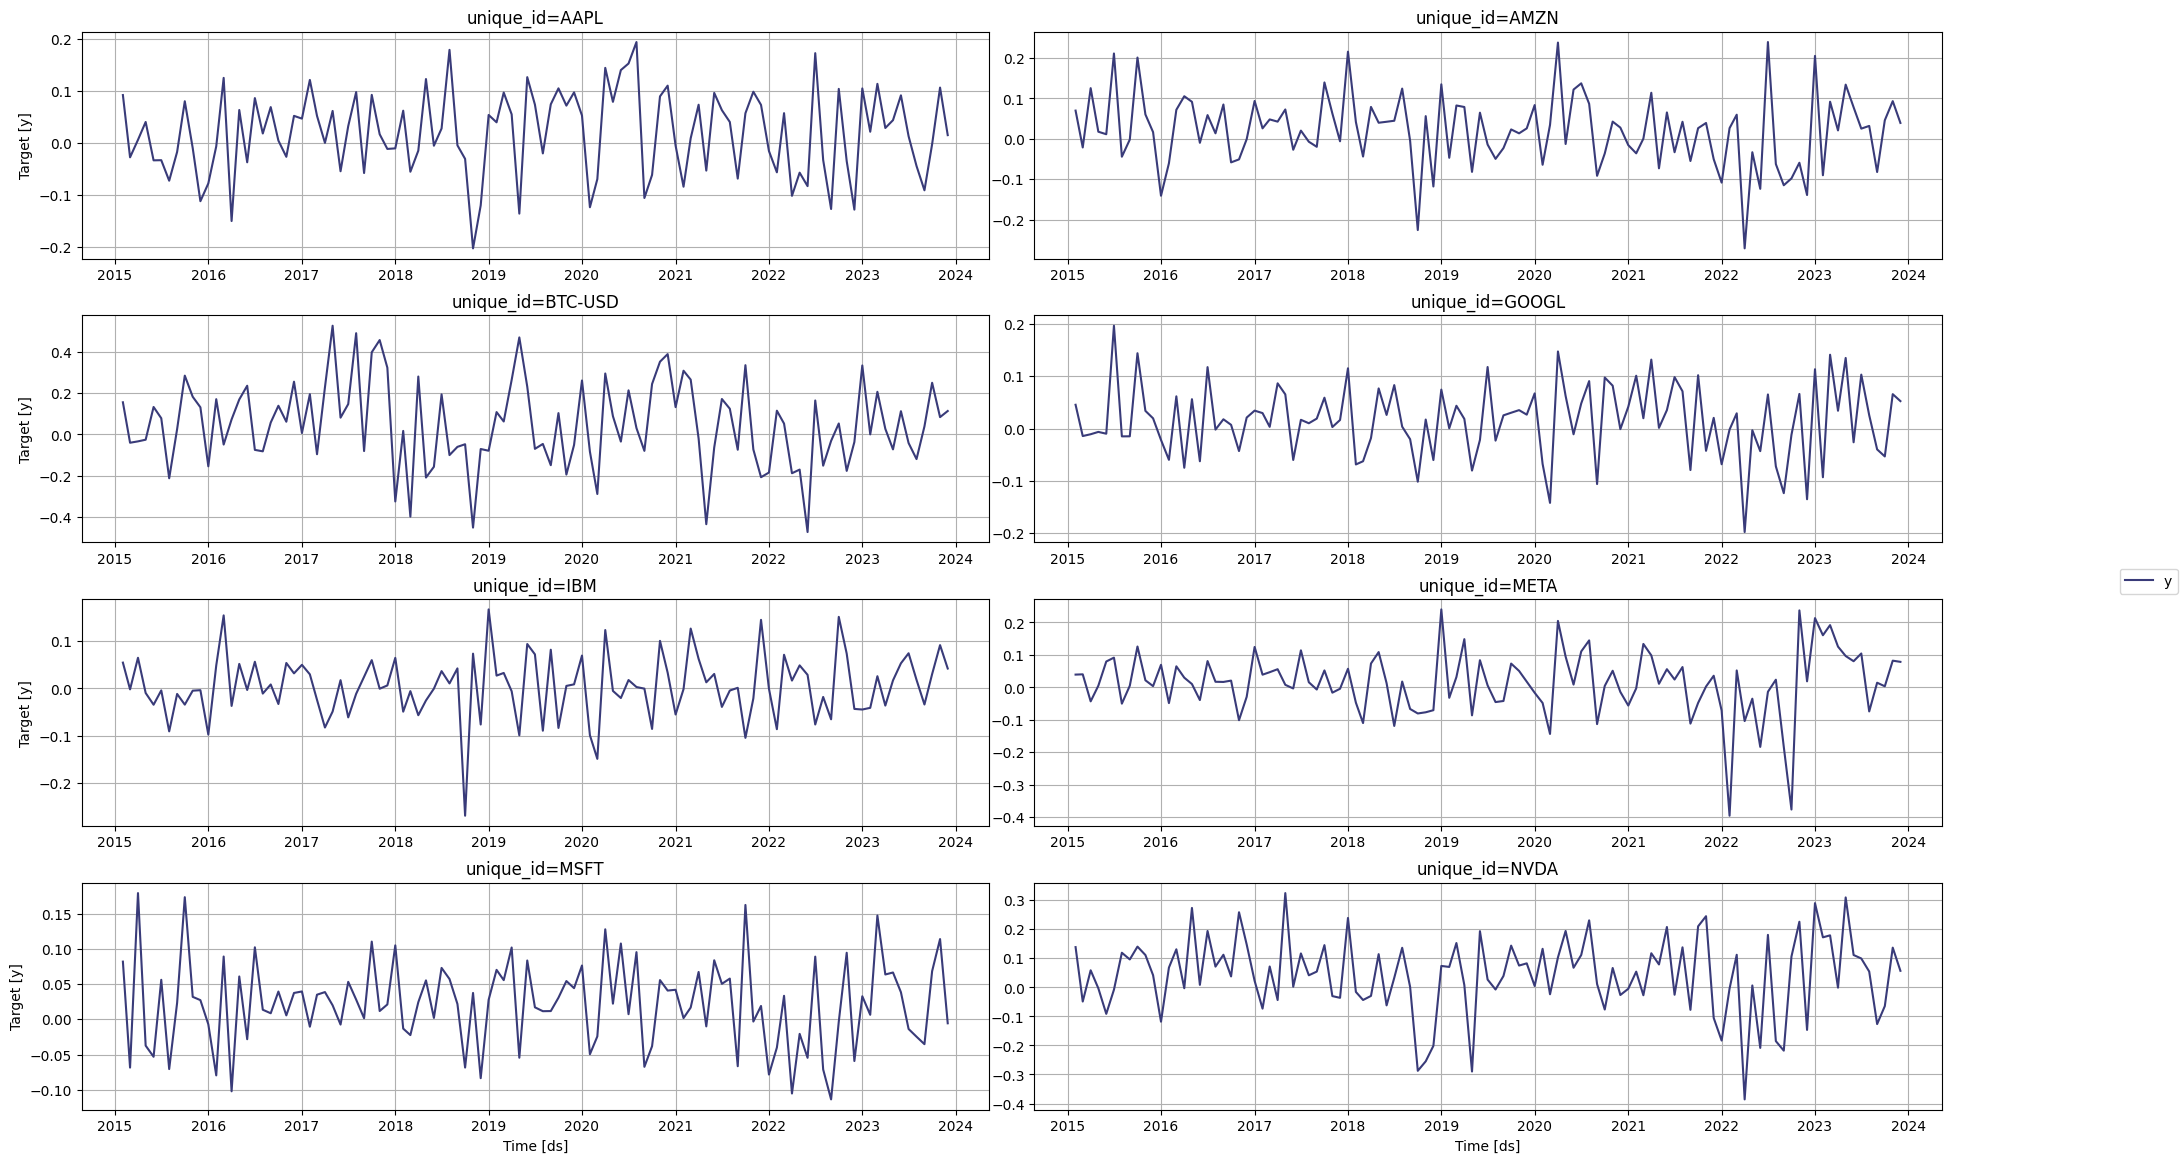

In [37]:
StatsForecast.plot(Y_df)

In [38]:
season_length=12
horizon = 3

models = [
    Naive(),
    AutoARIMA(season_length=season_length),
    AutoETS(season_length=season_length),
    AutoTheta(season_length=season_length),
    SeasonalNaive(season_length=season_length),
]

# Instantiate StatsForecast class with models, data frequency ('MS' for monthly),
# and parallel computation on all CPU cores (n_jobs=-1)
sf = StatsForecast(
    models=models, # models for forecasting
    freq='MS',  # frequency of the data
    n_jobs=1  # number of jobs to run in parallel, -1 means using all processors
)

In [39]:
# Generate forecasts for the specified horizon using the sf object
Y_hat_df = sf.forecast(df=Y_df, h=horizon) # forecast data
Y_hat_df.head() 

,ds,Naive,AutoARIMA,AutoETS,AutoTheta,SeasonalNaive
unique_id,,,,,,
AAPL,2024-01-01,0.014808,0.0,0.018681,0.015919,0.104829
AAPL,2024-02-01,0.014808,0.0,0.018681,0.015919,0.021393
AAPL,2024-03-01,0.014808,0.0,0.018681,0.015919,0.113647
AMZN,2024-01-01,0.039263,0.0,0.020148,0.019798,0.205174
AMZN,2024-02-01,0.039263,0.0,0.020148,0.019798,-0.090252


In [40]:
cv_df = sf.cross_validation(df=Y_df, h=horizon, n_windows=10, step_size=horizon, level=[90])
cv_df.head()

,ds,cutoff,y,Naive,Naive-lo-90,Naive-hi-90,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90,AutoETS,AutoETS-lo-90,AutoETS-hi-90,AutoTheta,AutoTheta-lo-90,AutoTheta-hi-90,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90
unique_id,,,,,,,,,,,,,,,,,,
AAPL,2021-07-01,2021-06-01,0.062958,0.096197,-0.086299,0.278694,0.0,-0.138350,0.138350,0.021238,-0.116234,0.158710,0.035782,-0.092494,0.197580,0.152834,-0.040299,0.345967
AAPL,2021-08-01,2021-06-01,0.040114,0.096197,-0.161892,0.354286,0.0,-0.138350,0.138350,0.021238,-0.116234,0.158710,0.036076,-0.111874,0.157789,0.194233,0.001101,0.387366
AAPL,2021-09-01,2021-06-01,-0.068965,0.096197,-0.219896,0.412291,0.0,-0.138350,0.138350,0.021238,-0.116234,0.158710,0.036369,-0.140448,0.172459,-0.106370,-0.299503,0.086763
AAPL,2021-10-01,2021-09-01,0.057002,-0.068965,-0.249252,0.111322,0.0,-0.137012,0.137012,0.020837,-0.115239,0.156913,0.025761,-0.101456,0.186223,-0.061888,-0.254182,0.130405
AAPL,2021-11-01,2021-09-01,0.098461,-0.068965,-0.323929,0.186000,0.0,-0.137012,0.137012,0.020837,-0.115239,0.156913,0.025761,-0.120777,0.146129,0.089481,-0.102813,0.281775


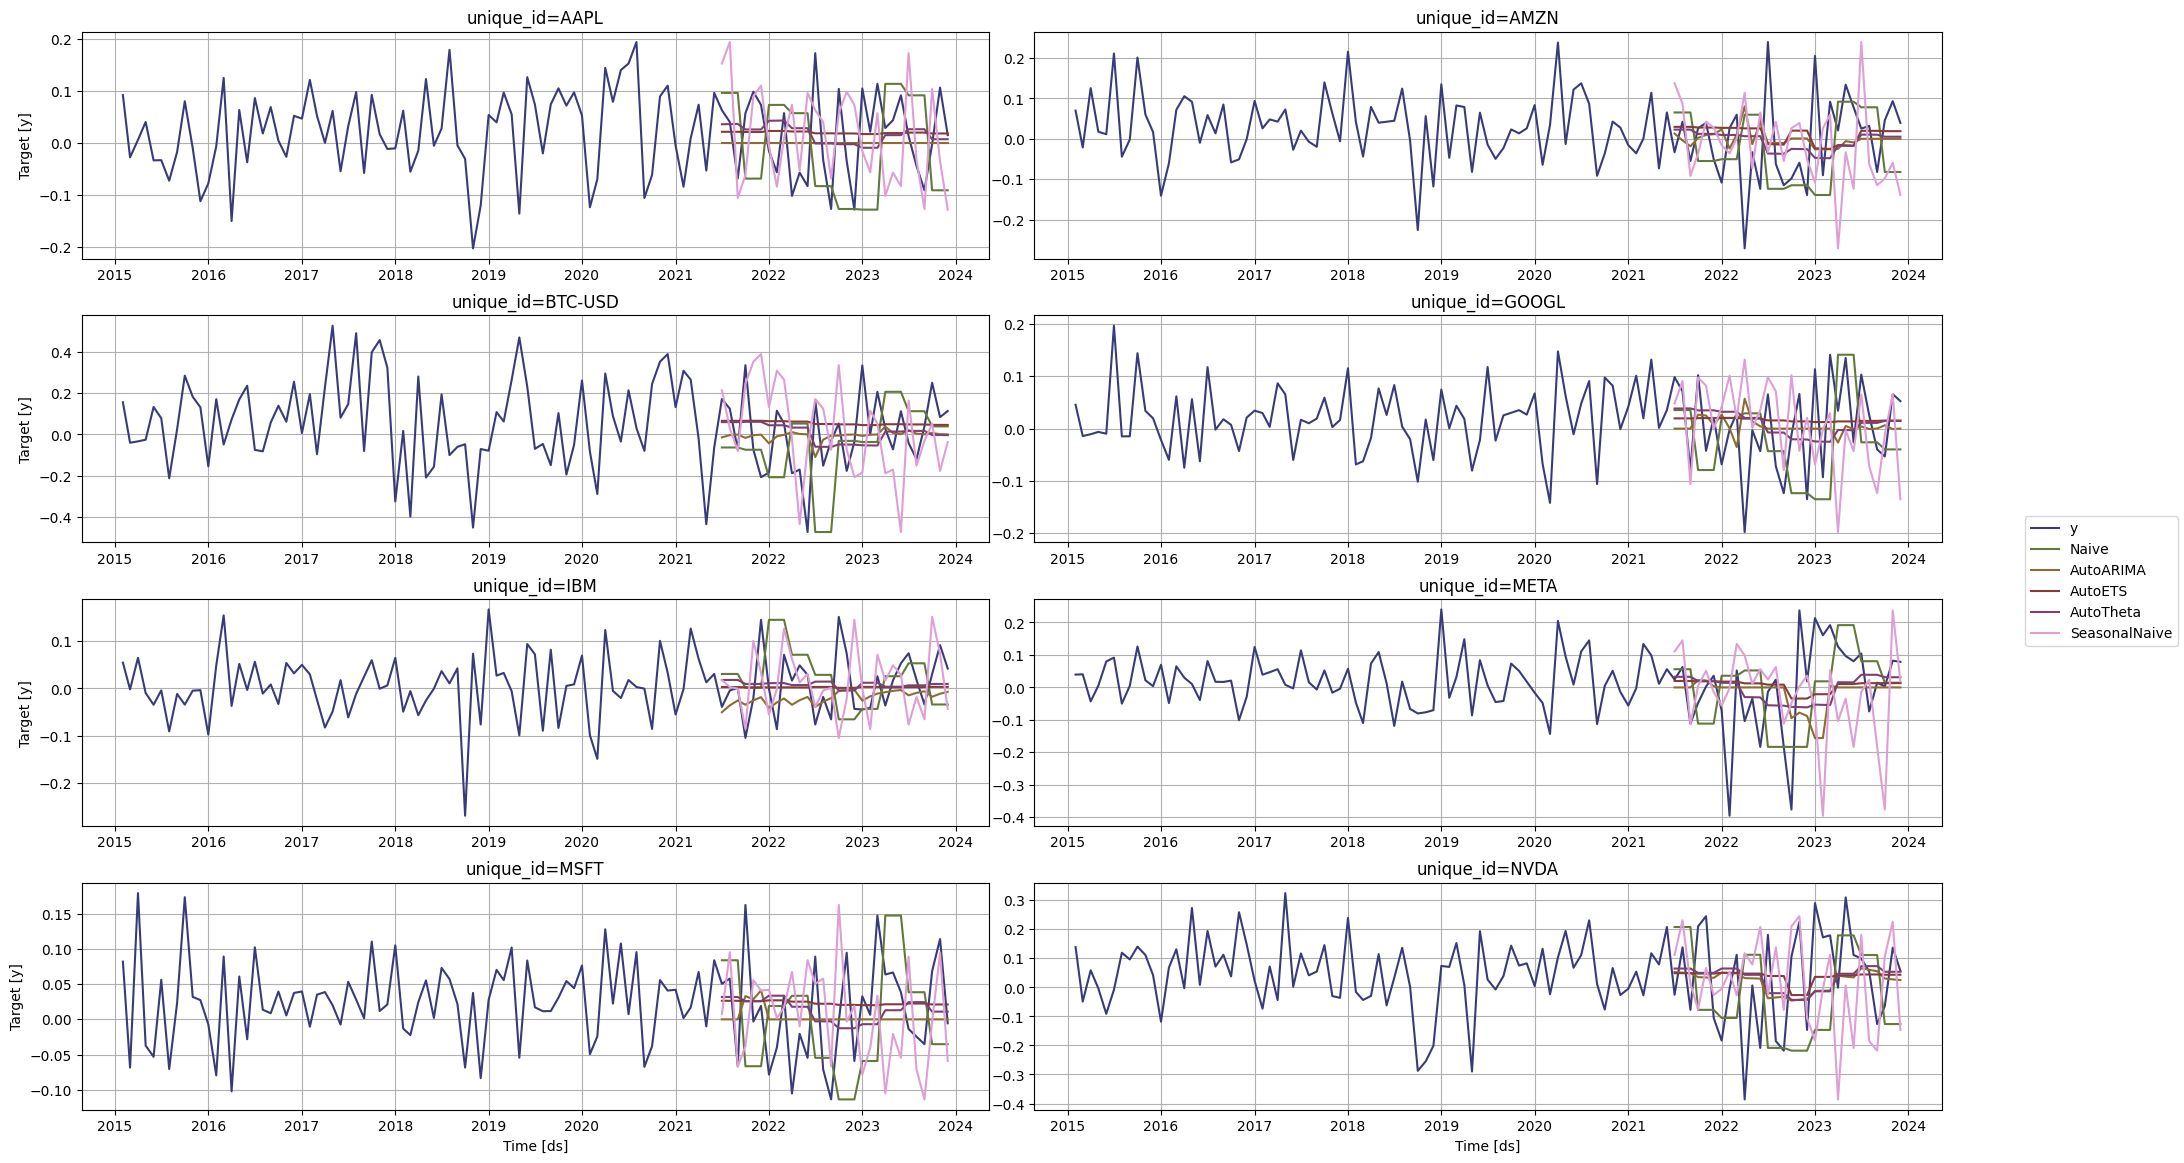

In [41]:
StatsForecast.plot(Y_df, cv_df.drop(['cutoff', 'y'], axis=1))

In [42]:
cv_df = pd.DataFrame(cv_df)
cv_df.index.name = 'unique_id'

# Transformar índice en columna
cv_df.reset_index(inplace=True)

In [43]:
def evaluate(df: pd.DataFrame, metrics: List[Callable]) -> pd.DataFrame:
    eval_ = {}
    models = df.loc[:, ~df.columns.str.contains('unique_id|y|ds|cutoff|lo|hi')].columns
    for model in models:
        eval_[model] = {}
        for metric in metrics:
            eval_[model][metric.__name__] = metric(df['y'], df[model])
    eval_df = pd.DataFrame(eval_).rename_axis('metric').reset_index()
    eval_df.insert(0, 'cutoff', df['cutoff'].iloc[0])
    eval_df.insert(0, 'unique_id', df['unique_id'].iloc[0])
    return eval_df

In [44]:
str_models = cv_df.loc[:, ~cv_df.columns.str.contains('unique_id|y|ds|cutoff|lo|hi')].columns
str_models = ','.join([f"{model}:float" for model in str_models])
cv_df['cutoff'] = cv_df['cutoff'].astype(str)
cv_df['unique_id'] = cv_df['unique_id'].astype(str)

In [53]:
evaluation_df = transform(
    cv_df.loc[:, ~cv_df.columns.str.contains('lo|hi')], 
    evaluate, 
    engine="dask",
    params={'metrics': [mse, mae, smape]}, 
    schema=f"unique_id:str,cutoff:str,metric:str, {str_models}", 
    as_local=True,
    partition={'by': ['unique_id', 'cutoff']}
)

In [58]:
evaluation_df

,unique_id,cutoff,metric,Naive,AutoARIMA,AutoETS,AutoTheta,SeasonalNaive
0,AAPL,2022-12-01,mse,0.045291,0.008121,0.005707,0.009743,0.007958
1,AAPL,2022-12-01,mae,0.208718,0.079956,0.06308,0.089526,0.085135
2,AAPL,2022-12-01,smape,200.0,200.0,105.473984,200.0,155.382675
3,AAPL,2023-06-01,mse,0.01942,0.00351,0.005522,0.006351,0.009022
4,AAPL,2023-06-01,mae,0.132679,0.049624,0.060872,0.067343,0.069237
...,...,...,...,...,...,...,...,...
25,NVDA,2023-03-01,mae,0.126196,0.130267,0.126928,0.125121,0.336135
26,NVDA,2023-03-01,smape,99.983147,154.250336,147.939117,142.839417,196.883209
27,NVDA,2023-09-01,mse,0.035614,0.007331,0.006865,0.006977,0.026194
28,NVDA,2023-09-01,mae,0.169555,0.078763,0.071678,0.068288,0.154525


In [59]:
# Calculate the mean metric for each cross validation window
evaluation_df.groupby(['cutoff', 'metric']).mean(numeric_only=True)

Naive   AutoARIMA     AutoETS   AutoTheta  \
cutoff     metric                                                   
2021-06-01 mae       0.095155    0.069709    0.063066     0.06414   
           mse       0.015293     0.00635    0.005629    0.006044   
           smape   131.026917  182.072922   134.45665  128.329834   
2021-09-01 mae       0.128884    0.091541    0.089391    0.089921   
           mse       0.026383    0.014882    0.014194    0.013981   
           smape   160.609695  159.071487  136.951675  140.430527   
2021-12-01 mae       0.115857    0.085675    0.082465    0.085669   
           mse        0.02429    0.013695    0.015459    0.015641   
           smape   147.615555  184.798737  144.121002  145.701309   
2022-03-01 mae       0.172895    0.137592    0.148713    0.136238   
           mse       0.047458    0.034886    0.039219    0.034798   
           smape   184.337448  192.324783  193.994278  173.395813   
2022-06-01 mae       0.152975    0.107038    0.114443    0.108211   
           mse       0.050192    0.017028    0.017977    0.016036   
           smape   121.334732  170.358704  175.708878  164.828018   
2022-09-01 mae       0.140707    0.113135    0.116819    0.107904   
           mse       0.034612    0.019228    0.020543    0.018394   
           smape   122.638069  191.849564  179.345764   154.40744   
2022-12-01 mae       0.187454    0.140327    0.119316    0.146654   
           mse       0.049851    0.031477    0.020651      0.0317   
           smape    165.74556  184.897934  154.682419  185.422333   
2023-03-01 mae       0.090087    0.076034    0.068308    0.069374   
           mse       0.012033    0.008699    0.007825    0.007815   
           smape    92.514908  182.969971  139.819412  150.675095   
2023-06-01 mae       0.091578     0.05461     0.05855    0.059201   
           mse         0.0126    0.004754    0.005689     0.00561   
           smape   143.840317  182.017532  138.923157  144.908249   
2023-09-01 mae       0.106766    0.071312    0.057548    0.064111   
           mse        0.01534     0.00759    0.005121    0.006829   
           smape    164.35228  191.319977  127.295654  146.268204   

                   SeasonalNaive  
cutoff     metric                 
2021-06-01 mae          0.058659  
           mse          0.005665  
           smape       96.071312  
2021-09-01 mae          0.116889  
           mse          0.032906  
           smape      138.617767  
2021-12-01 mae          0.103665  
           mse          0.019647  
           smape      145.927231  
2022-03-01 mae          0.171494  
           mse          0.050682  
           smape      156.671005  
2022-06-01 mae          0.099072  
           mse          0.017215  
           smape      121.699829  
2022-09-01 mae          0.135725  
           mse          0.024705  
           smape      151.663605  
2022-12-01 mae            0.1665  
           mse          0.050057  
           smape      158.108002  
2023-03-01 mae           0.18533  
           mse          0.050736  
           smape      178.183289  
2023-06-01 mae          0.097938  
           mse          0.013699  
           smape      132.440887  
2023-09-01 mae          0.130567  
           mse          0.023997  
           smape      152.705444

<Axes: xlabel='error', ylabel='model'>

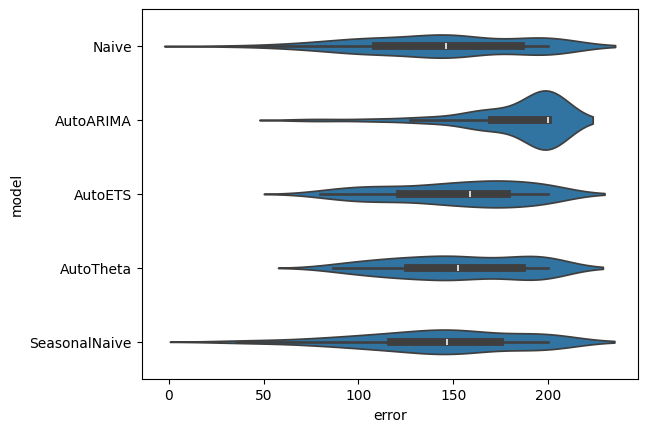

In [60]:
evaluation_df_melted = pd.melt(evaluation_df, id_vars=['unique_id', 'cutoff', 'metric'], var_name='model', value_name='error')
sns.violinplot(evaluation_df_melted.query('metric=="smape"'), x='error', y='model')

<Axes: xlabel='n', ylabel='best_model'>

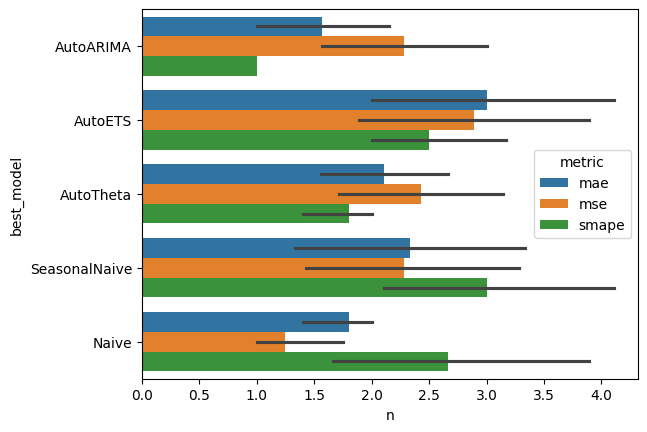

In [61]:
# Choose the best model for each time series, metric, and cross validation window
evaluation_df['best_model'] = evaluation_df.idxmin(axis=1, numeric_only=True)
# count how many times a model wins per metric and cross validation window
count_best_model = evaluation_df.groupby(['cutoff', 'metric', 'best_model']).size().rename('n').to_frame().reset_index()
# plot results
sns.barplot(count_best_model, x='n', y='best_model', hue='metric')